# Introduction

In this notebook we will analyse the NYC taxi data using Spark in Databricks!
We have a huge dataset (billions of rows!!),and leveraging Spark and Databricks is a good approach to handle this massive data. 
With spark, we can use the power of Clould Databricks and its delta lake technologie to compute millions of rows in seconds.

Bellow you'll see how we can awnser the bellow questions using this technologie:

• How many trips happens in a day in NYC? 

• What was the yearly revenue for a vendor in a given year?

• Has the number of trips declined in the past years?

• Do we have more trips happening inside Manhattan, or going to another boroughs? 

• What about revenue? Is Manhattan the main source of revenue?

• What happens more, shorter or longer trips?

# Installing and Importing libraries 

In [0]:
%pip install geopandas

Python interpreter will be restarted.
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.5
    Not uninstalling numpy at /databricks/python3/lib/python3.9/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-753e78d0-ba05-4e76-8a52-be987e7909a7
    Can't uninstall 'numpy'. No files were found to uninstall.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scipy 1.7.3 requires numpy<1.23.0,>=1.16.5, but you have numpy 1.26.4 which is incompatible.
Python interpreter will be restarted.


In [0]:
%pip install contextily

Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
from pyspark.sql.functions import year, month,dayofmonth, when, col, dayofweek, to_date, avg, desc
from pyspark.sql import functions as F
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import requests
import zipfile
import os
import contextily as cx

---------------------------------------------------------------------------
ModuleNotFoundError                       Traceback (most recent call last)
File <command-4295304395061598>:4
      2 from pyspark.sql import functions as F
      3 import pandas as pd
----> 4 import geopandas as gpd
      5 import matplotlib.pyplot as plt
      6 import requests

File /databricks/python_shell/dbruntime/PythonPackageImportsInstrumentation/__init__.py:171, in _create_import_patch.<locals>.import_patch(name, globals, locals, fromlist, level)
    166 thread_local._nest_level += 1
    168 try:
    169     # Import the desired module. If you’re seeing this while debugging a failed import,
    170     # look at preceding stack frames for relevant error information.
--> 171     original_result = python_builtin_import(name, globals, locals, fromlist, level)
    173     is_root_import = thread_local._nest_level == 1
    174     # `level` represents the number of leading dots in a relative import stateme

In [0]:
# https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf
# https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page

# Selecting datasources

In [0]:
display(dbutils.fs.ls('/databricks-datasets/nyctaxi'))

path name size modificationTime dbfs:/databricks-datasets/nyctaxi/readme_nyctaxi.txt readme_nyctaxi.txt 916 1590473418000 dbfs:/databricks-datasets/nyctaxi/reference/ reference/ 0 0 dbfs:/databricks-datasets/nyctaxi/sample/ sample/ 0 0 dbfs:/databricks-datasets/nyctaxi/tables/ tables/ 0 0 dbfs:/databricks-datasets/nyctaxi/taxizone/ taxizone/ 0 0 dbfs:/databricks-datasets/nyctaxi/tripdata/ tripdata/ 0 0

In [0]:
# Get the list of files in the directory
files = dbutils.fs.ls('/databricks-datasets/nyctaxi')

# Open the first file
if len(files) > 0:
    first_file_path = files[0].path
    content = dbutils.fs.head(first_file_path)
    print(content)
else:
    print("No files found in the directory.")



NYC Taxi Dataset
This dataset was obtained from https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page.  The source of the data is: The New York City Taxi Commision, Office of Legal Affairs, 33 Beaver Street, 22nd Floor, New York, NY 10004; Attn.: Records Access Officer


Data Set Information
This dataset contains aggregated data containing information from the NYC Taxi and Limousine on their various indicators, trip counts, crash history, etc., and also raw trip data from a variety of sources. 
	
License and/or Citation
Public domain--this data is freely available without restriction from https://www1.nyc.gov/site/tlc/about/request-data.page  




In [0]:
# load the data
df = spark.read.format("delta").load("dbfs:/databricks-datasets/nyctaxi/tables/nyctaxi_yellow/")

df.show(5)

+---------+-------------------+-------------------+---------------+-------------+----------------+---------------+------------+------------------+-----------------+----------------+------------+-----------+-----+-------+----------+------------+------------+
|vendor_id|    pickup_datetime|   dropoff_datetime|passenger_count|trip_distance|pickup_longitude|pickup_latitude|rate_code_id|store_and_fwd_flag|dropoff_longitude|dropoff_latitude|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|total_amount|
+---------+-------------------+-------------------+---------------+-------------+----------------+---------------+------------+------------------+-----------------+----------------+------------+-----------+-----+-------+----------+------------+------------+
|      VTS|2009-11-07 19:44:00|2009-11-07 19:49:00|              2|         0.74|      -73.992127|      40.734658|        null|              null|        -73.99197|       40.729115|        CASH|        4.5|  0.0|    0.5|      

In [0]:
df.printSchema()

root
 |-- vendor_id: string (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- rate_code_id: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- total_amount: double (nullable = true)



In [0]:
df.count()

Out[6]: 1611611035

We have almost 2 Billion rows!

# Data processing

In [0]:
df = df.drop(*['rate_code_id', 'payment_type'])

We can see how many trips we have each year

In [0]:
df.groupBy(year("pickup_datetime").alias("pickup_year")).count().orderBy('pickup_year').show()

+-----------+---------+
|pickup_year|    count|
+-----------+---------+
|       2001|       15|
|       2002|       33|
|       2003|       23|
|       2008|      585|
|       2009|170896987|
|       2010|169001154|
|       2011|176897208|
|       2012|178544324|
|       2013|173179759|
|       2014|165114361|
|       2015|146112990|
|       2016|131165043|
|       2017|113496933|
|       2018|102803387|
|       2019| 84397753|
|       2020|      438|
|       2021|        1|
|       2026|        3|
|       2029|        6|
|       2031|        2|
+-----------+---------+
only showing top 20 rows



Let's focus our analyses in a shorter period of time

In [0]:
df = df.filter((year('pickup_datetime') > 2011 ) & (year('pickup_datetime')<2019)) 

In [0]:
df = df.withColumn("vendor_name", 
                                when(df["vendor_id"] == 1, "Creative Mobile Technologies")
                                .when(df["vendor_id"] == 2, "VeriFone")
                                .otherwise("Other"))

In [0]:
df = df.drop(*['passenger_count','store_and_fwd_flag','extra','mta_tax','tip_amount','tolls_amount','total_amount'])

# Data analyses

#### What is the yearly renenue by vendor? 

In [0]:
# revenue by vendor in 2018
df.filter(year('pickup_datetime') == 2018)\
    .groupBy('vendor_name').sum('fare_amount')\
    .withColumnRenamed('sum(fare_amount)', '2018_revenue')\
    .orderBy(desc('2018_revenue'))\
    .show()

+--------------------+-------------+
|         vendor_name| 2018_revenue|
+--------------------+-------------+
|            VeriFone| 2.94992055E7|
|Creative Mobile T...|2.136263755E7|
|               Other|     245349.0|
+--------------------+-------------+



We can see that from the two main companies, VeriFone has a bigger revenue than Creative Mobile Technologies in 2018. But how about the other years?

In [0]:
df_year_vendor = df.filter((col('vendor_id') == '1') |(col('vendor_id') == '2'))\
                    .withColumn('year_pickup', year('pickup_datetime'))\
                    .groupBy('year_pickup','vendor_name').sum('fare_amount')\
                    .withColumnRenamed('sum(fare_amount)', 'yearly_revenue')
                    .orderBy('year_pickup')

df_year_vendor.show()

+-----------+--------------------+--------------------+
|year_pickup|         vendor_name|      yearly_revenue|
+-----------+--------------------+--------------------+
|       2016|Creative Mobile T...|4.3158330041000146E8|
|       2015|Creative Mobile T...| 8.919945104800155E8|
|       2017|Creative Mobile T...| 2.544360841000011E7|
|       2018|Creative Mobile T...| 2.136263755000001E7|
|       2015|            VeriFone|  9.98528820479997E8|
|       2016|            VeriFone|4.9559610434000206E8|
|       2018|            VeriFone|        2.94992055E7|
|       2017|            VeriFone|3.0997461999999993E7|
+-----------+--------------------+--------------------+



Let's pivot it to better understanding

In [0]:
df_year_vendor.groupBy('year_pickup').pivot('vendor_name').agg(F.first('yearly_revenue')).orderBy('year_pickup').show()

+-----------+----------------------------+--------------------+
|year_pickup|Creative Mobile Technologies|            VeriFone|
+-----------+----------------------------+--------------------+
|       2015|         8.919945104800155E8|  9.98528820479997E8|
|       2016|        4.3158330041000146E8|4.9559610434000206E8|
|       2017|         2.544360841000011E7|3.0997461999999993E7|
|       2018|         2.136263755000001E7|        2.94992055E7|
+-----------+----------------------------+--------------------+



#### What the monthly number of trips looks like? Has that increased or decresed along the years?

We can plot a chart to check how many trips each vendor is making by month. But firts, let's save the aggregated data and convert it into a pandas df

In [0]:
df_year_month_vendor = df.filter((col('vendor_id') == '1') |(col('vendor_id') == '2'))\
                            .withColumn('year_pickup', year('pickup_datetime'))\
                            .withColumn('month_pickup', month('pickup_datetime'))\
                            .groupBy('year_pickup','month_pickup','vendor_name')\
                            .count().withColumnRenamed('count', 'number_trips')\
                            .orderBy(*['vendor_name', 'year_pickup', 'month_pickup'])

In [0]:
df_ymv_pd = df_year_month_vendor.toPandas()
df_ymv_pd

year_pickup 
 month_pickup 
 vendor_name 
 number_trips 
 
 
 
 
 0 
 2015 
 1 
 Creative Mobile Technologies 
 6101189 
 
 
 1 
 2015 
 2 
 Creative Mobile Technologies 
 5945708 
 
 
 2 
 2015 
 3 
 Creative Mobile Technologies 
 6402968 
 
 
 3 
 2015 
 4 
 Creative Mobile Technologies 
 6275210 
 
 
 4 
 2015 
 5 
 Creative Mobile Technologies 
 6307405 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 91 
 2018 
 8 
 VeriFone 
 4694478 
 
 
 92 
 2018 
 9 
 VeriFone 
 4748758 
 
 
 93 
 2018 
 10 
 VeriFone 
 5098364 
 
 
 94 
 2018 
 11 
 VeriFone 
 4752004 
 
 
 95 
 2018 
 12 
 VeriFone 
 4851366 
 
 
 
 96 rows × 4 columns

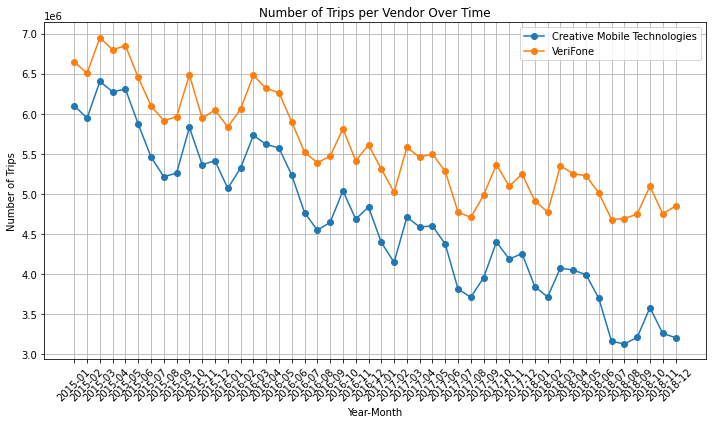

In [0]:
df_ymv_pd['year_month_pickup'] = df_ymv_pd['year_pickup'].astype(str) + '-' + df_ymv_pd['month_pickup'].astype(str).str.zfill(2)

plt.figure(figsize=(10, 6))

for vendor in df_ymv_pd['vendor_name'].unique():
    vendor_data = df_ymv_pd[df_ymv_pd['vendor_name'] == vendor]
    plt.plot(vendor_data['year_month_pickup'], vendor_data['number_trips'], marker='o', label=vendor)

plt.xlabel('Year-Month')
plt.ylabel('Number of Trips')
plt.title('Number of Trips per Vendor Over Time')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

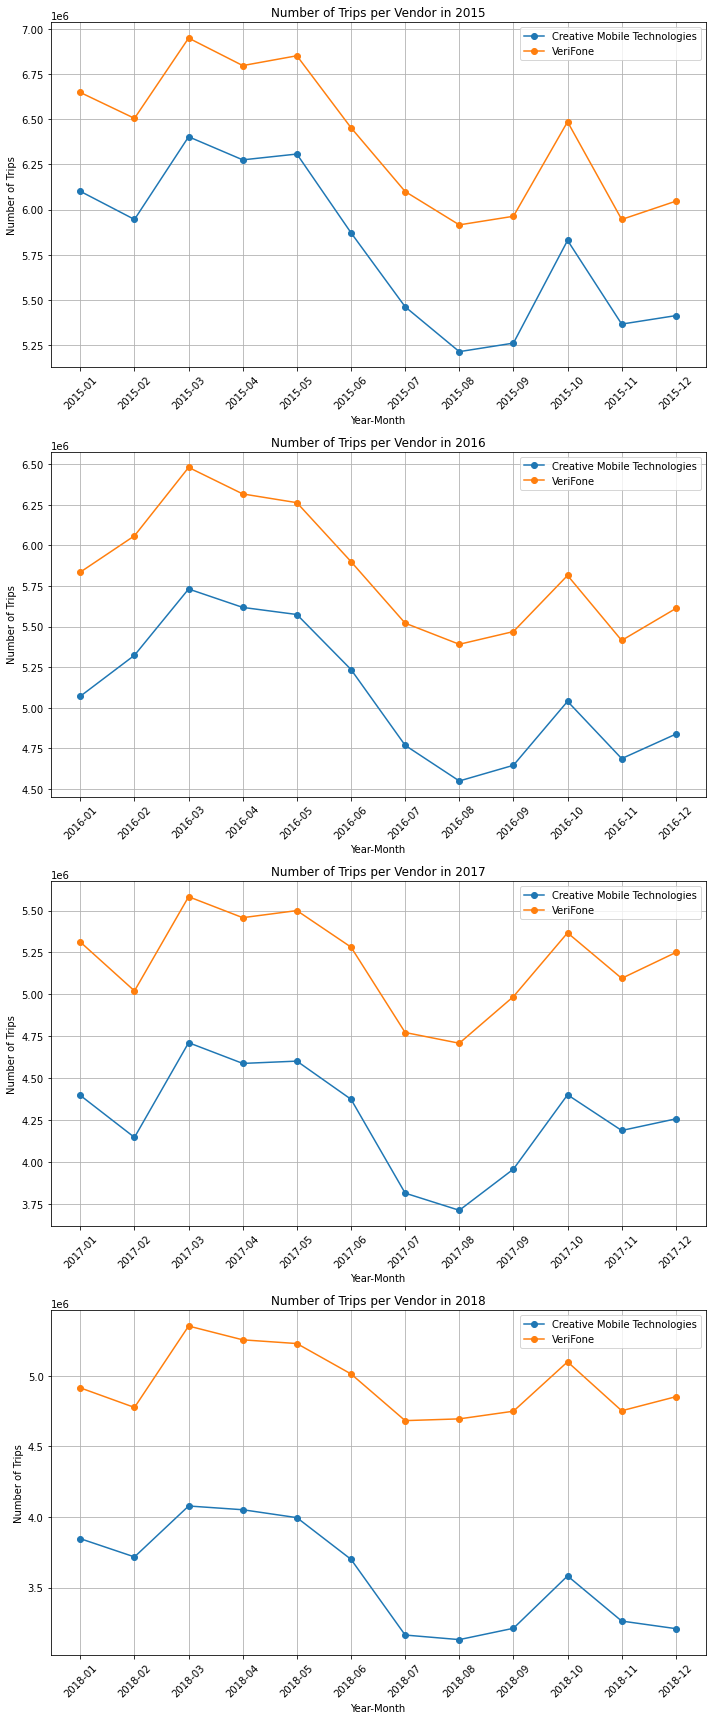

In [0]:
years = df_ymv_pd['year_pickup'].unique()

fig, axs = plt.subplots(len(years), 1, figsize=(10, 6 * len(years)))

if len(years) == 1:
    axs = [axs]

for i, year in enumerate(years):
    ax = axs[i]
    year_data = df_ymv_pd[df_ymv_pd['year_pickup'] == year]
    for vendor in year_data['vendor_name'].unique():
        vendor_data = year_data[year_data['vendor_name'] == vendor]
        ax.plot(vendor_data['year_month_pickup'], vendor_data['number_trips'], marker='o', label=vendor)

    ax.set_xlabel('Year-Month')
    ax.set_ylabel('Number of Trips')
    ax.set_title(f'Number of Trips per Vendor in {year}')
    ax.legend()
    ax.grid(True)
    ax.set_xticks(vendor_data['year_month_pickup'])
    ax.set_xticklabels(vendor_data['year_month_pickup'], rotation=45)

plt.tight_layout()
plt.show()

We can note that both vendors has a similar trend and seasonality. Also both have a downwards trend for number of trips. 
Let's how is the average number of trips by each day of the week, and by time 

In [0]:
df_day_count = df.withColumn('date_pickup', to_date(col('pickup_datetime')))\
                .groupBy('date_pickup','vendor_name')\
                .count().withColumnRenamed('count', 'number_trips')\
                .orderBy(*['date_pickup'])

df_dayweek_avg = df_day_count.withColumn('day_week_pickup', dayofweek('date_pickup'))\
                            .groupBy('day_week_pickup').avg('number_trips')\
                            .withColumnRenamed('avg(number_trips)', 'avg_trips')\
                            .orderBy(*['day_week_pickup']) 

df_dayweek_avg.show()                    

+---------------+------------------+
|day_week_pickup|         avg_trips|
+---------------+------------------+
|              1| 217908.4383116883|
|              2|210815.44588045235|
|              3| 229122.2353896104|
|              4|238671.06991869918|
|              5|243764.33063209077|
|              6| 249077.0436187399|
|              7|248680.43993506493|
+---------------+------------------+



Note how the number of trips increases as the weekend approches, with the most numbers of trips happening on Fridays and Saturdays. 
What about the hour? At which time does people prefer to take a taxi?

In [0]:
df_dayhour_count = df.withColumn('date_pickup', to_date(col('pickup_datetime')))\
                    .withColumn("hour", F.hour(F.date_trunc("hour", col("pickup_datetime"))))\
                    .groupBy('date_pickup','hour')\
                    .count().withColumnRenamed('count', 'number_trips')

df_hour_avg = df_dayhour_count.groupBy('hour').avg('number_trips')\
                .withColumnRenamed('avg(number_trips)', 'avg_number_trips')\
                .orderBy('hour')

df_hour_avg_pd = df_hour_avg.toPandas()

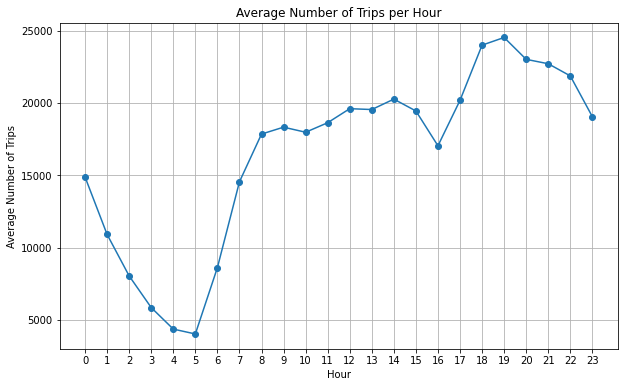

In [0]:
plt.figure(figsize=(10, 6))
plt.plot(df_hour_avg_pd['hour'], df_hour_avg_pd['avg_number_trips'], marker='o')

plt.title('Average Number of Trips per Hour')
plt.xlabel('Hour')
plt.ylabel('Average Number of Trips')
plt.xticks(range(0, 24)) 
plt.grid(True)
plt.show()

# Processing Geo Data

Now let's take a look on the geography data. Unfortunately I could not find a way to combine the spatial data using spark, and it's the data is too heavy to be converted into a pandas df using the Databricks community version. So let's select a day as our sample data, and focus on that.

In [0]:
df = df.drop(*['vendor_id'])

In [0]:
df_may16 = df.filter((year('pickup_datetime') == 2016) & (month('pickup_datetime') == 5)& (dayofmonth('pickup_datetime') == 6)) #friday
df_may16.cache() 

Out[8]: DataFrame[pickup_datetime: timestamp, dropoff_datetime: timestamp, trip_distance: double, pickup_longitude: double, pickup_latitude: double, dropoff_longitude: double, dropoff_latitude: double, fare_amount: double, vendor_name: string]

In [0]:
# convert to pandas dataframe
df_may16 = df_may16.toPandas()

In [0]:
df_may16.head(5)

pickup_datetime 
 dropoff_datetime 
 trip_distance 
 pickup_longitude 
 pickup_latitude 
 dropoff_longitude 
 dropoff_latitude 
 fare_amount 
 vendor_name 
 
 
 
 
 0 
 2016-05-06 00:00:39 
 2016-05-06 00:11:53 
 1.98 
 -73.988274 
 40.722118 
 -74.001450 
 40.740189 
 9.5 
 VeriFone 
 
 
 1 
 2016-05-06 00:00:40 
 2016-05-06 00:26:48 
 5.90 
 -73.987938 
 40.728249 
 -73.975327 
 40.654976 
 22.5 
 Creative Mobile Technologies 
 
 
 2 
 2016-05-06 00:00:40 
 2016-05-06 00:12:23 
 2.57 
 -73.988838 
 40.748581 
 -73.989929 
 40.775921 
 10.5 
 VeriFone 
 
 
 3 
 2016-05-06 00:00:47 
 2016-05-06 00:15:28 
 2.60 
 -73.996208 
 40.748306 
 -73.980492 
 40.782284 
 12.5 
 Creative Mobile Technologies 
 
 
 4 
 2016-05-06 00:00:48 
 2016-05-06 00:08:28 
 1.40 
 -73.989044 
 40.748516 
 -73.994232 
 40.761387 
 7.0 
 Creative Mobile Technologies

In [0]:
df_may16 = df_may16[(df_may16['pickup_longitude'] != 0)] #removing rows with data quality issue
df_may16 = df_may16[(df_may16['pickup_latitude'] != 0)] 
df_may16 = df_may16[(df_may16['dropoff_latitude'] != 0)] 
df_may16 = df_may16[(df_may16['dropoff_longitude'] != 0)] 

Now let's transform our dataframe into geodataframes for pickup and dropoff, and see how they look like

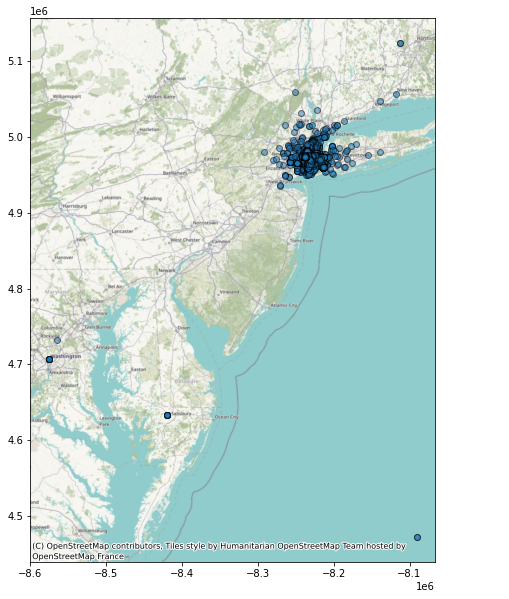

In [0]:
# PICKUP
gdf_pickup = gpd.GeoDataFrame(
    df_may16, 
    geometry=gpd.points_from_xy(df_may16['pickup_longitude'], df_may16['pickup_latitude'])
)

# Set the CRS to EPSG:4326 (WGS84)
gdf_pickup.set_crs(epsg=4326, inplace=True)

# Convert the CRS to EPSG:3857 (Web Mercator)
gdf_pickup = gdf_pickup.to_crs(epsg=3857)

# Plot the GeoDataFrame
ax = gdf_pickup.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
cx.add_basemap(ax)

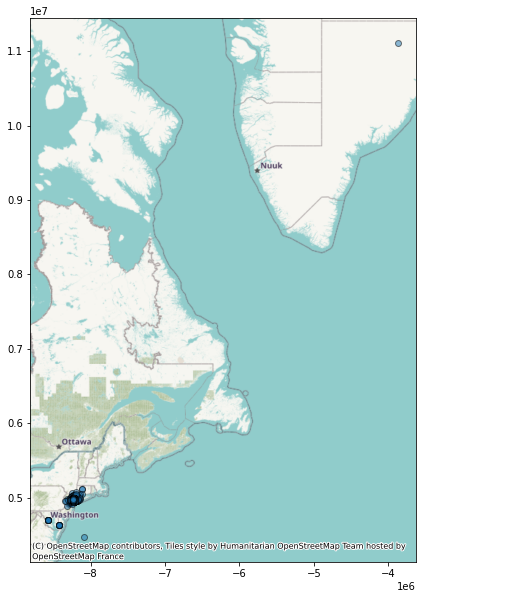

In [0]:
# DROPOFF
gdf_dropoff = gpd.GeoDataFrame(
    df_may16, 
    geometry=gpd.points_from_xy(df_may16['dropoff_longitude'], df_may16['dropoff_latitude'])
)

# Set the CRS to EPSG:4326 (WGS84)
gdf_dropoff.set_crs(epsg=4326, inplace=True)

# Convert the CRS to EPSG:3857 (Web Mercator)
gdf_dropoff = gdf_dropoff.to_crs(epsg=3857)

# Plot the GeoDataFrame
ax = gdf_dropoff.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
cx.add_basemap(ax)

We still see some strange locations. That's not an issue, when we join that with our NYC zones that'll go away. 
We will extract that straight from the website, and plot it.

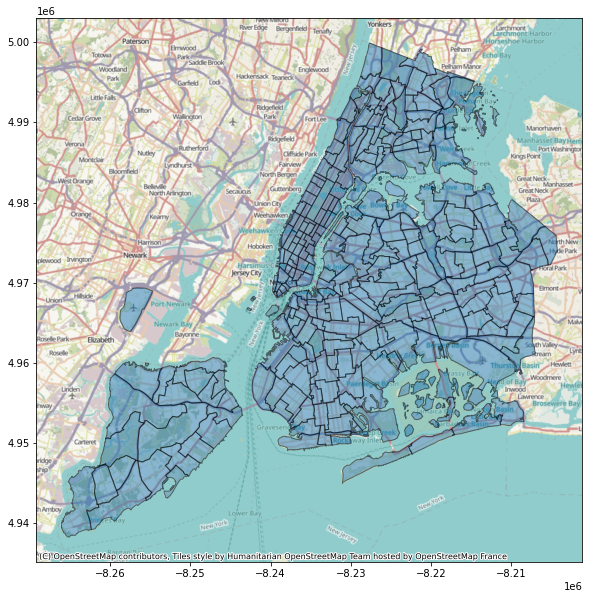

In [0]:
# TAXI ZONES BASED ON GEO COORDINATES
url = "https://d37ci6vzurychx.cloudfront.net/misc/taxi_zones.zip"
local_zip = "taxi_zones.zip"
response = requests.get(url)
with open(local_zip, "wb") as file:
    file.write(response.content)

# extract the zip file
extracted_folder = "taxi_zones"
with zipfile.ZipFile(local_zip, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder)

# load the shapefile into GeoDataFrame
shapefile_path = os.path.join(extracted_folder, "taxi_zones.shp")
gdf_zone = gpd.read_file(shapefile_path)

gdf_zone = gdf_zone.to_crs(epsg=3857)

ax = gdf_zone.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
cx.add_basemap(ax)

In [0]:
gdf_zone.head()

OBJECTID 
 Shape_Leng 
 Shape_Area 
 zone 
 LocationID 
 borough 
 geometry 
 
 
 
 
 0 
 1 
 0.116357 
 0.000782 
 Newark Airport 
 1 
 EWR 
 POLYGON ((-8258175.533 4967457.203, -8258179.5... 
 
 
 1 
 2 
 0.433470 
 0.004866 
 Jamaica Bay 
 2 
 Queens 
 MULTIPOLYGON (((-8217980.622 4959237.286, -821... 
 
 
 2 
 3 
 0.084341 
 0.000314 
 Allerton/Pelham Gardens 
 3 
 Bronx 
 POLYGON ((-8220713.534 4993383.154, -8220638.4... 
 
 
 3 
 4 
 0.043567 
 0.000112 
 Alphabet City 
 4 
 Manhattan 
 POLYGON ((-8234500.227 4971984.094, -8234502.1... 
 
 
 4 
 5 
 0.092146 
 0.000498 
 Arden Heights 
 5 
 Staten Island 
 POLYGON ((-8257036.109 4948033.095, -8256954.5...

Now let's join our data and plot it. Our main goal here it's to translate the geocoordinates into zones and boroughs

In [0]:
gdf_pickup = gpd.sjoin(gdf_pickup, gdf_zone[['geometry','zone', 'LocationID', 'borough']], how="inner", predicate='within')
gdf_dropoff = gpd.sjoin(gdf_dropoff, gdf_zone[['geometry','zone', 'LocationID', 'borough']], how="inner", predicate='within') 

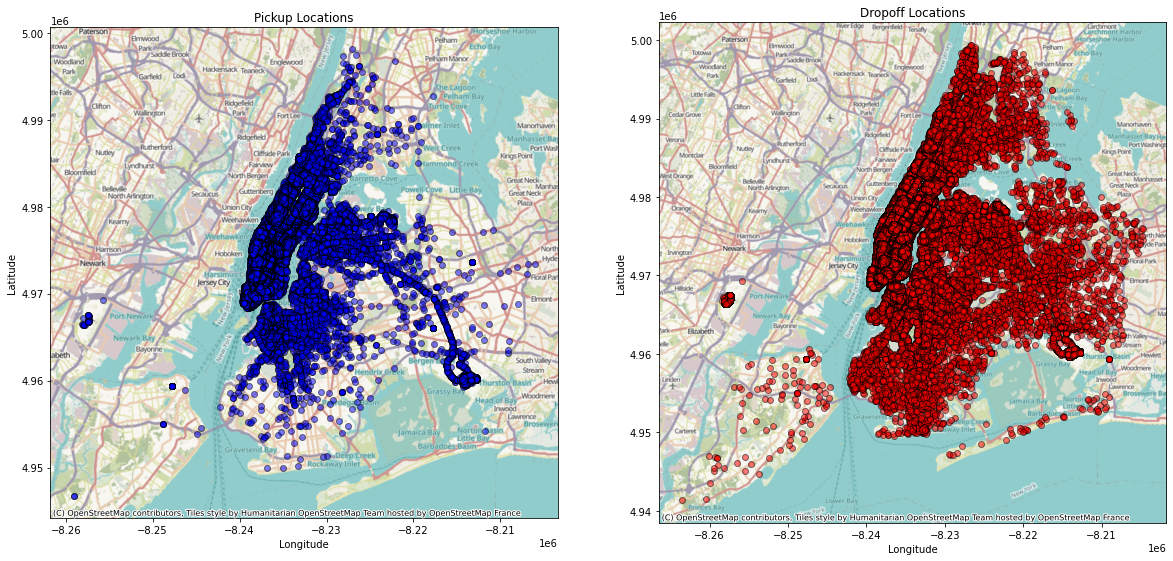

In [0]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Plot pickup locations
gdf_pickup.plot(ax=ax1, color='blue', alpha=0.5, edgecolor='k')
ax1.set_title('Pickup Locations')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
cx.add_basemap(ax1)

# Plot dropoff locations
gdf_dropoff.plot(ax=ax2, color='red', alpha=0.5, edgecolor='k')
ax2.set_title('Dropoff Locations')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
cx.add_basemap(ax2)

plt.show()

Impressive how many trips we have in a single day!
Now we can bring the information we wanted back to our main dataframe

In [0]:
gdf_pickup = gdf_pickup[['zone','LocationID','borough']]
gdf_dropoff = gdf_dropoff[['zone','LocationID','borough']]

gdf_pickup.rename(columns={'zone': 'pickup_zone',
                           'LocationID':'pickup_LocationID',
                           'borough': 'pickup_borough'
                           }, inplace=True)

gdf_dropoff.rename(columns={'zone': 'dropoff_zone',
                           'LocationID':'dropoff_LocationID',
                           'borough': 'dropoff_borough'
                           }, inplace=True)    

<command-1226389544569304>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdf_pickup.rename(columns={'zone': 'pickup_zone',
<command-1226389544569304>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdf_dropoff.rename(columns={'zone': 'dropoff_zone',


In [0]:
df_joined = pd.merge(df_may16, gdf_pickup, left_index=True, right_index=True, how='inner')
df_joined = pd.merge(df_joined, gdf_dropoff, left_index=True, right_index=True, how='inner')

In [0]:
df_joined.head(2)

pickup_datetime 
 dropoff_datetime 
 trip_distance 
 pickup_longitude 
 pickup_latitude 
 dropoff_longitude 
 dropoff_latitude 
 fare_amount 
 vendor_name 
 pickup_zone 
 pickup_LocationID 
 pickup_borough 
 dropoff_zone 
 dropoff_LocationID 
 dropoff_borough 
 
 
 
 
 0 
 2016-05-06 00:00:39 
 2016-05-06 00:11:53 
 1.98 
 -73.988274 
 40.722118 
 -74.001450 
 40.740189 
 9.5 
 VeriFone 
 Lower East Side 
 148 
 Manhattan 
 Flatiron 
 90 
 Manhattan 
 
 
 1 
 2016-05-06 00:00:40 
 2016-05-06 00:26:48 
 5.90 
 -73.987938 
 40.728249 
 -73.975327 
 40.654976 
 22.5 
 Creative Mobile Technologies 
 East Village 
 79 
 Manhattan 
 Windsor Terrace 
 257 
 Brooklyn

Alright, so we have our dataset with the pickup and dropoff locations. 
First analyses we can do it's which routes are used the most, and which provides the most revenue 

In [0]:
trips_agg = df_joined.groupby(['pickup_borough', 'dropoff_borough'])\
                        .fare_amount.agg(['sum','count']).reset_index()\
                        .rename(columns={'sum': 'Total Revenue', 'count': 'N. of Trips'})

total_trips = trips_agg['N. of Trips'].sum()
total_rev = trips_agg['Total Revenue'].sum()

trips_agg['% Revenue'] = (trips_agg['Total Revenue']/total_rev)*100
trips_agg['% Trips'] = (trips_agg['N. of Trips']/total_trips)*100

trips_agg.sort_values(by=['Total Revenue'], ascending = False).head(10)

pickup_borough 
 dropoff_borough 
 Total Revenue 
 N. of Trips 
 % Revenue 
 % Trips 
 
 
 
 
 15 
 Manhattan 
 Manhattan 
 3729385.71 
 362492 
 65.713678 
 84.386029 
 
 
 16 
 Manhattan 
 Queens 
 560453.05 
 16881 
 9.875469 
 3.929799 
 
 
 21 
 Queens 
 Manhattan 
 510291.56 
 12844 
 8.991598 
 2.990008 
 
 
 13 
 Manhattan 
 Brooklyn 
 344958.51 
 14710 
 6.078345 
 3.424402 
 
 
 19 
 Queens 
 Brooklyn 
 123341.00 
 3144 
 2.173331 
 0.731905 
 
 
 22 
 Queens 
 Queens 
 114030.97 
 6544 
 2.009284 
 1.523405 
 
 
 14 
 Manhattan 
 EWR 
 70145.78 
 1018 
 1.236004 
 0.236984 
 
 
 12 
 Manhattan 
 Bronx 
 68474.00 
 2360 
 1.206547 
 0.549394 
 
 
 5 
 Brooklyn 
 Brooklyn 
 61969.74 
 5944 
 1.091938 
 1.383729 
 
 
 7 
 Brooklyn 
 Manhattan 
 43329.50 
 2137 
 0.763488 
 0.497481

Note how the trips inside Manhattan predominates over the others, especially in number of trips. 
Also funny the difference between the % in revenue and % in trips. But that makes sense, since the longer trips charge more.

What about the duration of the trips? Do we have more longer or shorter trips? Which generates the biggest revenue?
For that, we can split our data into beans: 0-10 minutes, 10-30 minutes and > 30 minutes trips

In [0]:
df_joined['trip_duration_min'] = (df_joined['dropoff_datetime'] - df_joined['pickup_datetime']).dt.total_seconds() / 60

bins = [0, 10, 30, float('inf')]
labels = ['0-10 minutes', '10-30 minutes', '>30 minutes']

df_joined['trip_duration_category'] = pd.cut(df_joined['trip_duration_min'], bins=bins, labels=labels, right=False)

trip_cat_agg = df_joined.groupby(['trip_duration_category'])\
                        .fare_amount.agg(['sum','count']).reset_index()\
                        .rename(columns={'sum': 'Total Revenue', 'count': 'N. of Trips'})

total_trips = trip_cat_agg['N. of Trips'].sum()
total_rev = trip_cat_agg['Total Revenue'].sum()

trip_cat_agg['% Revenue'] = (trip_cat_agg['Total Revenue']/total_rev)*100
trip_cat_agg['% Trips'] = (trip_cat_agg['N. of Trips']/total_trips)*100

trip_cat_agg.sort_values(by=['Total Revenue'], ascending = False)

trip_duration_category 
 Total Revenue 
 N. of Trips 
 % Revenue 
 % Trips 
 
 
 
 
 1 
 10-30 minutes 
 2965144.28 
 211325 
 52.247354 
 49.195231 
 
 
 2 
 >30 minutes 
 1604841.27 
 45183 
 28.278122 
 10.518340 
 
 
 0 
 0-10 minutes 
 1105219.08 
 173056 
 19.474524 
 40.286430